## Objetivos de aprendizado

Ao final desta lição, você será capaz de:

* Encadeie várias etapas de processamento de dados usando `Pipeline`
* Use o objeto `KFolds` para dividir os dados em várias dobras.
* Execute a validação cruzada usando o SciKit Learn com `cross_val_predict` e `GridSearchCV`


In [20]:
#eliminar avisos no cod
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#libs
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [25]:
# carregamento do html
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle

boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))

'wget' não é reconhecido como um comando interno
ou externo, um programa operável ou um arquivo em lotes.


In [26]:
#abrindo as chaves do arquivo
boston.keys()

dict_keys(['dataframe', 'description'])

In [27]:
#inclui em um dataframe
boston_data = boston['dataframe']
boston_description = boston['description']

In [28]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Para fazer a divisão vou usar o KFold do SciKit Learn

In [29]:
#divisao dos dados
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [31]:
# divisao de 3 kfold ou ou seja dois originais, 1 copia
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [32]:
#treino os dados 
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [ ]:
#importaçaõ do sklearn com metricas me traz o score do treino

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

## Pipeline e validação cruzada


`Pipeline` permite encadear vários operadores nos dados, ambos com um método `fit`.

In [34]:
s = StandardScaler()
lr = LinearRegression()

### Processamento Pipeline

Um pipeline contém uma série de etapas, em que uma etapa é ("nome da etapa", modelo_real). A string "nome da etapa" é usada apenas para ajudá-lo a identificar em qual etapa está e para permitir que  especifique parâmetros nessa etapa.

In [35]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [36]:
cross_val_predict
cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

SyntaxError: invalid syntax (1468014829.py, line 2)

In [37]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

### Validação cruzada com Kfold ajustando nos nós transformando adequadamente em cada etapa do caminho

In [38]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [39]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [40]:
r2_score(y, predictions)

0.7063531064161559

In [ ]:
np.mean(scores) 

Observe que `cross_val_predict` não usa o mesmo modelo para todas as etapas; as previsões para cada linha são feitas quando essa linha está no conjunto de validação. Nós realmente temos os resultados coletados de 3 (ou seja, `kf.num_splits`) modelos diferentes.

O 'estimador' ainda não foi ajustado. Se prever com dados _novos_, ainda tem que treinar nosso `estimador`.


## Ajustando os hiperparâmetros

### Definição

**Ajustando os hiperparâmetros** envolve o uso de validação cruzada (ou divisão de teste de treinamento) para determinar quais hiperparâmetros têm maior probabilidade de gerar um modelo que _generaliza_ bem fora de sua amostra.

### Mecânica

Posso gerar um intervalo de valores de espaços exponencialmente usando o numpy 

In [41]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

O código abaixo ajusta o hiperparâmetro `alpha` para a regressão Lasso.

In [42]:
#ajustando o hiperparametro
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [43]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602441),
 (1e-06, 0.7063531882052065),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083234),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884887)]

In [44]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [45]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

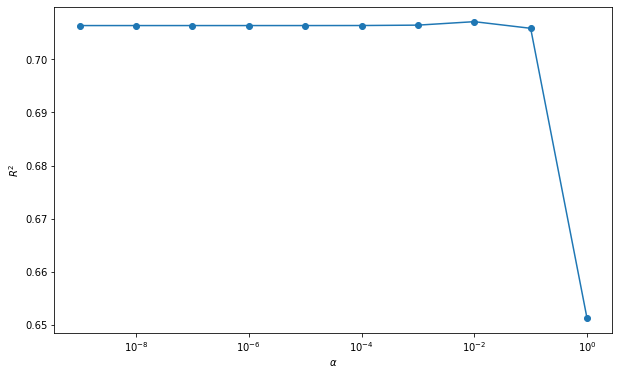

In [46]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercício

Adicione `PolynomialFeatures` a este `Pipeline` e execute novamente a validação cruzada com o `PolynomialFeatures` adicionado.

**Dica nº 1:** os pipelines processam a entrada do primeiro ao último. Pense na ordem em que faria sentido adicionar recursos polinomiais aos dados em sequência e adicioná-los no local apropriado no pipeline.

**Dica nº 2:** você verá um aumento significativo na precisão da validação cruzada ao fazer isso

In [47]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

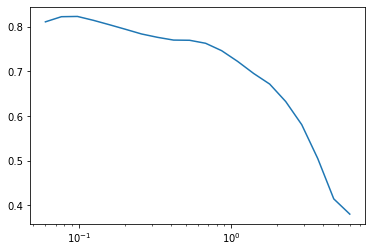

In [48]:
plt.semilogx(alphas, scores);

In [50]:
# Uma vez encontrado o hiperparâmetro (alpha~1e-2=0.01)
# faço o modelo e treinei em TODOS os dados
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.913477773519652

In [51]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

### Exercício

Faça o mesmo, mas com a regressão `Ridge`

Qual modelo, `Ridge` ou `Lasso`, tem melhor desempenho com seus hiperparâmetros ideais no conjunto de dados de Boston?

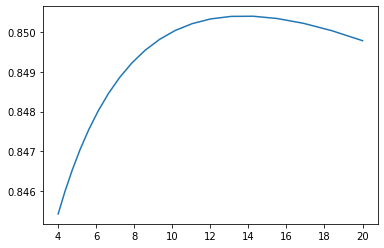

In [52]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)


**Conclusão:** Lasso e Ridge com ajuste adequado de hiperparâmetros fornecem melhores resultados do que a simples regressão linear!


### Exercício:

Agora, para qualquer que seja o seu melhor hiperparâmetro geral:

* Padronizar os dados
* Ajustar e prever em todo o conjunto de dados
* Veja quais foram os maiores coeficientes
    * Dica: use
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    para o seu modelo `model` para obter os nomes dos recursos de `PolynomialFeatures`.
    
    Então, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    para ver quais recursos no DataFrame `PolynomialFeatures` correspondem a quais colunas no DataFrame original.

In [53]:
# Uma vez encontrado o hiperparâmetro (alpha~1e-2=0.01)
# faça o modelo e treine-o em TODOS os dados
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.913477773519652

In [58]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

In [55]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [56]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [57]:
df_importances.sort_values(by=1)

NameError: name 'df_importances' is not defined

## GridSearchCV

Para fazer a validação cruzada, usei duas técnicas:
-`KFolds` e crie manualmente um loop para fazer a validação cruzada
- `cross_val_predict` e `score` para obter uma pontuação cruzada em algumas linhas.

Para fazer o ajuste de hiperparâmetros, vemos um padrão geral:
- use `cross_val_predict` e `score` em um loop escrito manualmente sobre hiperparâmetros e selecione o melhor.

Talvez não surpreendentemente, existe uma função que faz isso -- `GridSearchCV`

In [60]:
from sklearn.model_selection import GridSearchCV


estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [61]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [62]:
grid.best_score_, grid.best_params_

(0.8504982950750944,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.153673507519274})

In [63]:
y_predict = grid.predict(X)

In [64]:
# Isso inclui dentro e fora da amostra
r2_score(y, y_predict)

0.9149145594213683

In [65]:
# Observe que "grid" é um objeto de ajuste!
# Podemos usar grid.predict(X_test) para obter novas previsões!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.27346408e-01, -6.16205046e-03,  2.36135244e-02,
        1.00398027e-01, -9.74110586e-01,  3.26236441e+00, -9.65057238e-01,
       -1.96344725e+00,  8.56769182e-01, -1.01488960e+00, -7.06985966e-01,
        5.52029222e-01, -3.03254502e+00,  7.74127927e-02,  7.24276605e-02,
        6.82776638e-02,  1.72849044e+00, -4.80758341e-01,  5.76219972e-01,
        1.28132069e-01,  2.22931335e-01, -7.45243542e-01,  1.66582495e-01,
       -8.00025634e-02, -8.54571642e-02,  5.07490801e-01,  2.14820391e-01,
       -1.48833274e-01,  1.42098626e-01,  1.93770221e-01,  5.02304885e-02,
       -1.12667821e-01, -2.77559685e-01, -1.32870713e-01,  7.32239658e-01,
        5.26857333e-02,  8.89966580e-02, -2.72228558e-01,  5.84383917e-01,
        1.06306947e-01,  9.62971619e-01,  5.76845132e-01,  5.33378179e-01,
        7.07913980e-01, -6.21760626e-02,  7.57641545e-02, -4.28157866e-01,
        2.40651011e-01, -6.82201736e-01,  3.40931549e-01, -9.62217889e-01,
       -8.14997204e-01,  

In [66]:
grid.cv_results_

{'mean_fit_time': array([0.00464257, 0.00631674, 0.00365702, 0.00332459, 0.00332443,
        0.00332467, 0.00365678, 0.00398787, 0.00465345, 0.00565235,
        0.00465369, 0.00465417, 0.00565203, 0.00365035, 0.00332387,
        0.00332459, 0.00332514, 0.00399009, 0.00365686, 0.00432142,
        0.00465425, 0.00533032, 0.00465457, 0.00631658, 0.00464312,
        0.00565108, 0.00497548, 0.00533144, 0.0039773 , 0.003654  ,
        0.00466514, 0.0053188 , 0.00465457, 0.00997384, 0.00465465,
        0.00465425, 0.00565187, 0.00565132, 0.00531848, 0.004987  ,
        0.00797868, 0.00565147, 0.00698113, 0.00465361, 0.00565124,
        0.00532007, 0.0063165 , 0.00465369, 0.00432261, 0.00565195,
        0.00564011, 0.00465433, 0.00398946, 0.00465465, 0.00664965,
        0.00631452, 0.00432181, 0.00531888, 0.00631801, 0.0059824 ,
        0.01728725, 0.01329875, 0.01229962, 0.0116361 , 0.01263356,
        0.01396449, 0.01263269, 0.01330161, 0.012966  , 0.00930921,
        0.01229946, 0.01097147,